# Convert recording and sorting extractor data to TINT format

The Hussaini lab uses the proprietary TINT software from Axona to analyze extracellular electrophysiology data. While we are already able to read various data formats from Axona (`raw` data or `unit` data) into spikeinterface, perform preprocessing, spike sorting and export the data to NWB, we also want to allow to export data to the TINT format. 

The TINT format is essentially the same as the `unit` data, including `.X` and `.pos` files, but also `.cut` or `.clu`. The latter two contain information about the spike sorted units.

The conversion can be facilitated by using the existing tools from the Hussaini lab, which [convert `.bin` data to `.X` and `.pos`](https://github.com/HussainiLab/BinConverter/blob/master/BinConverter/core/ConversionFunctions.py). Some of this code is only relevant for using the GUI, which did not work for me. I cleared out GUI code and ran a conversion from `.bin` to `.X` and `.pos` in this notebook: [explore_hussaini_tools.ipynb](https://github.com/sbuergers/hussaini-lab-to-nwb-notebooks/blob/master/explore_hussaini_tools.ipynb).

They also already wrote a [`write_cut()`](https://github.com/GeoffBarrett/gebaSpike/blob/967097ec28592182ef9783d2d391930e1c63ca58/gebaSpike/core/writeCut.py) function.

We can test our solutions by reading data with these [Hussaini lab tools](https://github.com/HussainiLab/BinConverter/blob/master/BinConverter/core/Tint_Matlab.py). 

<a id='index'></a>
## Index

* [Testing functions](#testing_functions)
* [Hussaini-lab functions](#hussaini-lab_functions)
* [Convert Recording Extractor to TINT](#Convert_recording_extractor_to_tint)
* [Convert Sorting Extractor to TINT](#Convert_sorting_extractor_to_tint)

In [10]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({'font.size':14})
%matplotlib inline

import spikeextractors as se
import spiketoolkit as st

print(sys.version, sys.platform, sys.executable)

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0] linux /home/sbuergers/spikeinterface/spikeinterface_new_api/venv/bin/python


In [11]:
# Directories

dir_name = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin')
print('Input directory = ', dir_name)

save_dir = dir_name / 'conversion_to_tint'
save_dir.mkdir(parents=True, exist_ok=True)
print('Output directory = ', save_dir)

Input directory =  /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin
Output directory =  /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/conversion_to_tint


In [12]:
# Read cached spikeextractors data

r_cache = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_unit_data_no_bin_preproc.pkl'))

In [13]:
# Read NWB recording data

nwb_dir = Path(dir_name, 'nwb')
recording_nwb = se.NwbRecordingExtractor(nwb_dir / 'axona_tutorial_re2.nwb')

/home/sbuergers/spikeinterface/spikeinterface_new_api/venv/lib/python3.8/site-packages/hdmf/common/table.py:442: UserWarning: An attribute 'name' already exists on DynamicTable 'electrodes' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  warn(msg)


In [14]:
# Read NWB sorting data

sorting_nwb = se.NwbSortingExtractor(nwb_dir / 'axona_se_MS4.nwb', sampling_frequency=48000)

In [15]:
# Show data types of different objects

print(type(r_cache))
print(type(recording_nwb))
print(type(sorting_nwb))

<class 'spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor'>
<class 'spikeextractors.extractors.nwbextractors.nwbextractors.NwbRecordingExtractor'>
<class 'spikeextractors.extractors.nwbextractors.nwbextractors.NwbSortingExtractor'>


<a id="testing_functions"></a>
## Testing functions
[back to index](#index)

As we start exporting to putative TINT format, we will want to check if we can read it back in.

In [3]:
from spikeextractors.extractors.axonaunitrecordingextractor import AxonaUnitRecordingExtractor
import os


def test_axonaunitrecordingextractor(filename):
    '''Reads UNIT data with AxonaUnitRecordingExtractor and
    performs some simple operations as a sanity check. 
    
    Parameters
    ----------
    filename : str or Path
        Full filename of `.set` file (could be any extension actually)
    '''
    re = AxonaUnitRecordingExtractor(filename=filename)
    
    # TEST AXONARECORDINGEXTRACTOR
    # Retrieve some simple recording information and print it
    recording = re
    print('Channel ids = {}'.format(recording.get_channel_ids()))
    print('Num. channels = {}'.format(len(recording.get_channel_ids())))
    print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
    print('Num. timepoints = {}'.format(recording.get_num_frames()))
    print('Stdev. on third channel = {}'.format(np.std(recording.get_traces(channel_ids=2))))
    print('Location of third electrode = {}'.format(
        recording.get_channel_property(channel_id=2, property_name='location')))
    print('Channel groups = {}'.format(recording.get_channel_groups()))
    
    # TEST NEO_READER (axonaio)
    print(recording.neo_reader.header['signal_channels'])
    
    
def test_tetrode_files(filename):
    '''Reads UNIT data with AxonaUnitRecordingExtractor and
    performs some simple operations as a sanity check. 
    Will only test .X  and .set files (no .clu or .cut, no .pos).
    
    Parameters
    ----------
    filename : str or Path
        Full filename of `.set` file (could be any extension actually)
    '''
    test_axonaunitrecordingextractor(filename)

<a id="hussaini-lab_functions"></a>
## Hussaini-lab functions
[back to index](#index)

`gebaSpike` actually wants already existing `.cut` or `.clu` files, and allows modifying them. So these might not be all that useful for exporting to `.cut` or `.clu`.

In [4]:
# From 
# https://github.com/GeoffBarrett/gebaSpike/blob/967097ec28592182ef9783d2d391930e1c63ca58/gebaSpike/main.py

def save_function(self):
    """
    this method will save the .cut file
    :return:
    """
    if self.cut_filename.text() == default_filename:
        return

    save_filename = os.path.realpath(self.cut_filename.text())

    if os.path.exists(save_filename):
        self.choice = None
        self.LogError.signal.emit('OverwriteCut!%s' % save_filename)
        while self.choice is None:
            time.sleep(0.1)

        if self.choice != QtWidgets.QMessageBox.Yes:
            return

    if len(self.tetrode_data) == 0:
        return

    # organize the cut data
    n_spikes_expected = self.tetrode_data.shape[1]
    n_spikes = len(np.asarray([item for sublist in self.cell_indices.values() for item in sublist]))

    # check that with the manipulation of the spikes, that we still have the correct number of spikes
    if n_spikes != n_spikes_expected:
        self.choice = None
        self.LogError.signal.emit('cutSizeError')
        while self.choice is None:
            time.sleep(0.1)
        return

    # we will check if we are missing some of the spikes somehow. If we kept track of them, then the indices from
    # the spikes, when sorted, should produce an array from 0 -> N-1 spikes.
    if not np.array_equal(np.sort(np.asarray([item for sublist in self.cell_indices.values() for item in sublist])),
                      np.arange(len(self.cut_data_original))):
        self.choice = None
        self.LogError.signal.emit('cutIndexError')
        while self.choice is None:
            time.sleep(0.1)
        return

    cut_values = np.zeros(n_spikes)
    for cell, cell_indices in self.cell_indices.items():
        cut_values[cell_indices] = cell

    if '.clu.' in save_filename:
        # save the .clu filename
        write_clu(save_filename, cut_values)
        self.choice = None
        self.LogError.signal.emit('saveCompleteClu')
        while self.choice is None:
            time.sleep(0.1)
        self.actions_made = False

    else:
        # save the cut filename
        write_cut(save_filename, cut_values)
        self.choice = None
        self.LogError.signal.emit('saveComplete')
        while self.choice is None:
            time.sleep(0.1)
        self.actions_made = False

In [5]:
# From 
# https://github.com/GeoffBarrett/gebaSpike/blob/967097ec28592182ef9783d2d391930e1c63ca58/gebaSpike/core/writeCut.py

def write_cut(cut_filename, cut, basename=None):
    if basename is None:
        basename = os.path.basename(os.path.splitext(cut_filename)[0])

    unique_cells = np.unique(cut)

    if 0 not in unique_cells:
        # if it happens that there is no zero cell, add it anyways
        unique_cells = np.insert(unique_cells, 0, 0)  # object, index, value to insert

    n_clusters = len(np.unique(cut))
    n_spikes = len(cut)

    write_list = []  # the list of values to write

    tab = '    '  # the spaces didn't line up with my tab so I just created a string with enough spaces
    empty_space = '               '  # some of the empty spaces don't line up to x tabs

    # we add 1 to n_clusters because zero is the garbage cell that no one uses
    write_list.append('n_clusters: %d\n' % (n_clusters))
    write_list.append('n_channels: 4\n')
    write_list.append('n_params: 2\n')
    write_list.append('times_used_in_Vt:%s' % ((tab + '0') * 4 + '\n'))

    zero_string = (tab + '0') * 8 + '\n'

    for cell_i in np.arange(n_clusters):
        write_list.append(' cluster: %d center:%s' % (cell_i, zero_string))
        write_list.append('%smin:%s' % (empty_space, zero_string))
        write_list.append('%smax:%s' % (empty_space, zero_string))
    write_list.append('\nExact_cut_for: %s spikes: %d\n' % (basename, n_spikes))

    # now the cut file lists 25 values per row
    n_rows = int(np.floor(n_spikes / 25))  # number of full rows

    remaining = int(n_spikes - n_rows * 25)
    cut_string = ('%3u' * 25 + '\n') * n_rows + '%3u' * remaining

    write_list.append(cut_string % (tuple(cut)))

    with open(cut_filename, 'w') as f:
        f.writelines(write_list)

In [6]:
# From 
# https://github.com/GeoffBarrett/gebaSpike/blob/967097ec28592182ef9783d2d391930e1c63ca58/gebaSpike/core/writeCut.py

def write_clu(clu_filename, data):
    # the .clu files and the .cut files are different since the .clu files are the .cut files (with no manual sorting)
    # without the headers, and the values go from 1 -> N instead of 0 -> N, (1-based numbering instead of 0-based). Thus
    # we add 1 to the .cut data to get the .clu data

    data = np.asarray(data).astype(int)  # ensuring that the data is the integer data-type

    data += 1  # making the data 1-based instead of 0-based

    # calculating the number of clusters
    n_clust = len(np.unique(data))

    # ensuring that the cluster number is the 1st value
    data = np.concatenate(([n_clust], data))

    # saving the data as a column (delimter='\n') and integer format.
    np.savetxt(clu_filename, data, fmt='%d', delimiter='\n')

In [7]:
# From 
# https://github.com/HussainiLab/BinConverter/blob/master/BinConverter/core/ConvertTetrode.py

import os
from BinConverter.core.conversion_utils import get_set_header
import numpy as np
import struct


def write_tetrode(filepath, data, Fs):

    session_path, session_filename = os.path.split(filepath)
    tint_basename = os.path.splitext(session_filename)[0]
    set_filename = os.path.join(session_path, '%s.set' % tint_basename)

    n = len(data)

    header = get_set_header(set_filename)

    with open(filepath, 'w') as f:
        num_chans = 'num_chans 4'
        timebase_head = '\ntimebase %d hz' % (96000)
        bp_timestamp = '\nbytes_per_timestamp %d' % (4)
        # samps_per_spike = '\nsamples_per_spike %d' % (int(Fs*1e-3))
        samps_per_spike = '\nsamples_per_spike %d' % (50)
        sample_rate = '\nsample_rate %d hz' % (Fs)
        b_p_sample = '\nbytes_per_sample %d' % (1)
        # b_p_sample = '\nbytes_per_sample %d' % (4)
        spike_form = '\nspike_format t,ch1,t,ch2,t,ch3,t,ch4'
        num_spikes = '\nnum_spikes %d' % (n)
        start = '\ndata_start'

        write_order = [header, num_chans, timebase_head,
                       bp_timestamp,
                       samps_per_spike, sample_rate, b_p_sample, spike_form, num_spikes, start]

        f.writelines(write_order)

    # rearranging the data to have a flat array of t1, waveform1, t2, waveform2, t3, waveform3, etc....
    spike_times = np.asarray(sorted(data.keys()))

    # the spike times are repeated for each channel so lets tile this
    spike_times = np.tile(spike_times, (4, 1))
    spike_times = spike_times.flatten(order='F')

    spike_values = np.asarray([value for (key, value) in sorted(data.items())])

    # this will create a (n_samples, n_channels, n_samples_per_spike) => (n, 4, 50) sized matrix, we will create a
    # matrix of all the samples and channels going from ch1 -> ch4 for each spike time
    # time1 ch1_data
    # time1 ch2_data
    # time1 ch3_data
    # time1 ch4_data
    # time2 ch1_data
    # time2 ch2_data
    # .
    # .
    # .

    spike_values = spike_values.reshape((n * 4, 50))  # create the 4nx50 channel data matrix

    # make the first column the time values
    spike_array = np.hstack((spike_times.reshape(len(spike_times), 1), spike_values))

    data = None
    spike_times = None
    spike_values = None

    spike_n = spike_array.shape[0]

    t_packed = struct.pack('>%di' % spike_n, *spike_array[:, 0].astype(int))
    spike_array = spike_array[:, 1:]  # removing time data from this matrix to save memory

    spike_data_pack = struct.pack('<%db' % (spike_n*50), *spike_array.astype(int).flatten())

    spike_array = None

    # now we need to combine the lists by alternating

    comb_list = [None] * (2*spike_n)
    comb_list[::2] = [t_packed[i:i + 4] for i in range(0, len(t_packed), 4)]  # breaks up t_packed into a list,
    # each timestamp is one 4 byte integer
    comb_list[1::2] = [spike_data_pack[i:i + 50] for i in range(0, len(spike_data_pack), 50)]  # breaks up spike_data_
    # pack and puts it into a list, each spike is 50 one byte integers

    t_packed = None
    spike_data_pack = None

    write_order = []
    with open(filepath, 'rb+') as f:

        write_order.extend(comb_list)
        write_order.append(bytes('\r\ndata_end\r\n', 'utf-8'))

        f.seek(0, 2)
        f.writelines(write_order)

<a id="Convert_recording_extractor_to_tint"></a>
## Convert Recording extractor to TINT
[back to index](#index)

Hmm, since we are writing to TINT, thereby creating `.X` tetrode files, we throw away all information in-between spikes. There is no point to convert the fake continuous recording used for spike sorting to TINT at all. We really only want to export the spike sorting output!

In [12]:
# Anything to do here?

<a id="Convert_sorting_extractor_to_tint"></a>
## Convert Sorting extractor to TINT
[back to index](#index)

There are several points in the pipeline at which we might want to export to TINT. Ideally it should work for any `SortingExtractor` object!

In [13]:
print('Where do we load data from?\n', dir_name)

Where do we load data from?
 /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin


From a sorting extractor we can obtain a list unit spike sample arrays. We can convert this to the .clu or .cut type array of unit ID labels for each spike.


In [14]:
cut_filename = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Axona_Tint_1ms/20201004_Tint_1.cut')

basename = os.path.basename(os.path.splitext(cut_filename)[0])

print(basename)

20201004_Tint_1


In [15]:
filename = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Axona_Tint_1ms/20201004_Tint.set')
print(filename)

Path(str(filename.with_suffix('')) + '_{}'.format(1) + '.cut')

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Axona_Tint_1ms/20201004_Tint.set


PosixPath('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Axona_Tint_1ms/20201004_Tint_1.cut')

### Write unit labels to .cut and .clu files

In [16]:
def convert_spike_train_to_label_array(spike_train):
    '''Takes a list of arrays, where each array is a series of
    sample points at which a spike occured for a given unit
    (each list item is a unit). Converts to .cut array, i.e.
    orders spike samples from all units and labels each sample
    with the appropriate unit ID.
    
    Parameters
    ----------
    spike_train : List of np.arrays
        Output of `get_units_spike_train()` method of sorting extractor
        
    Return
    ------
    unit_labels_sorted : np.array
        Each entry is the unit ID corresponding to the spike sample that
        occured at this ordinal position
    '''

    # Generate Index array (indexing the unit for a given spike sample)
    unit_labels = []
    for i, l in enumerate(spike_train):
        unit_labels.append(np.ones((len(l),), dtype=int) * i)
    
    # Flatten lists and sort them
    spike_train_flat = np.concatenate(spike_train).ravel()
    unit_labels_flat = np.concatenate(unit_labels).ravel()

    sort_index = np.argsort(spike_train_flat)

    unit_labels_sorted = unit_labels_flat[sort_index]

    return unit_labels_sorted

In [17]:
def write_to_cut_file(cut_filename, unit_labels):
    '''Write spike sorting output to .cut file.
    
    Parameters
    ----------
    cut_filename : str or Path
        Full filename of .cut file to write to. A given .cut file belongs
        to a given tetrode file. For example, for tetrode `my_file.1`, the
        corresponding cut_filename should be `my_file_1.cut`.
    unit_labels : np.array
        Vector of unit labels for each spike sample (ordered by time of 
        occurence)
        
    Example
    -------
    # Given a sortingextractor called sorting_nwb:
    spike_train = sorting_nwb.get_units_spike_train()
    unit_labels = convert_spike_train_to_label_array(spike_train)
    write_to_cut_file(cut_filename, unit_labels)
    
    ---
    Largely based on gebaSpike implementation by Geoff Barrett
    https://github.com/GeoffBarrett/gebaSpike
    '''

    unique_cells = np.unique(unit_labels)

    n_clusters = len(np.unique(unit_labels))
    n_spikes = len(unit_labels)

    write_list = []

    tab = '    '
    empty_space = '               '

    write_list.append('n_clusters: %d\n' % (n_clusters))
    write_list.append('n_channels: 4\n')
    write_list.append('n_params: 2\n')
    write_list.append('times_used_in_Vt:%s' % ((tab + '0') * 4 + '\n'))

    zero_string = (tab + '0') * 8 + '\n'

    for cell_i in np.arange(n_clusters):
        write_list.append(' cluster: %d center:%s' % (cell_i, zero_string))
        write_list.append('%smin:%s' % (empty_space, zero_string))
        write_list.append('%smax:%s' % (empty_space, zero_string))
    write_list.append('\nExact_cut_for: %s spikes: %d\n' % (basename, n_spikes))

    # The unit label array consists of 25 values per row in .cut file
    n_rows = int(np.floor(n_spikes / 25))
    remaining = int(n_spikes - n_rows * 25)

    cut_string = ('%3u' * 25 + '\n') * n_rows + '%3u' * remaining

    write_list.append(cut_string % (tuple(unit_labels)))

    with open(cut_filename, 'w') as f:
        f.writelines(write_list)

In [18]:
def write_to_clu_file(clu_filename, unit_labels):
    ''' .clu files are pruned .cut files, containing only a long vector of unit
    labels, which are 1-indexed, instead of 0-indexed. In addition, the very first
    entry is the total number of units.
    
    Parameters
    ----------
    clu_filename : str or Path
        Full filename of .clu file to write to. A given .clu file belongs
        to a given tetrode file. For example, for tetrode `my_file.1`, the
        corresponding clu_filename should be `my_file_1.clu`.
    unit_labels : np.array
        Vector of unit labels for each spike sample (ordered by time of 
        occurence)
        
    ---
    Largely based on gebaSpike implementation by Geoff Barrett
    https://github.com/GeoffBarrett/gebaSpike
    '''
    unit_labels = np.asarray(unit_labels).astype(int)
    unit_labels += 1

    n_clust = len(np.unique(unit_labels))
    unit_labels = np.concatenate(([n_clust], unit_labels))

    np.savetxt(clu_filename, unit_labels, fmt='%d', delimiter='\n')

In [19]:
def set_cut_filename_from_basename(filename, tetrode_id):
    '''Given a str or Path object, assume the last entry after a slash
    is a filename, strip any file suffix, add tetrode ID label, and
    .cut suffix to name.
    
    Parameters
    ----------
    filename : str or Path
    tetrode_id : int
    '''
    return Path(str(filename).split('.')[0] + '_{}'.format(tetrode_id) + '.cut')

In [20]:
def write_unit_labels_to_file(sorting_extractor, filename):
    '''Write spike sorting output to .cut file, separately for each
    tetrode.
    
    Parameters
    ----------
    sorting_extractor : spikeextractors.SortingExtractor
    filename : str or Path
        Full filename of .set file or base-filename (i.e. the part of the
        filename all Axona files have in common). A given .cut file belongs
        to a given tetrode file. For example, for tetrode `my_file.1`, the
        corresponding cut_filename should be `my_file_1.cut`. This will be
        set automatically given the base-filename or set file.
        
    TODO: Any reason one might want to only convert some tetrodes or some
    samples? Should those be parameters?
    '''
    tetrode_ids = sorting_extractor.get_units_property(property_name='group')
    tetrode_ids = np.array(tetrode_ids)
    
    unit_ids = np.array(sorting_extractor.get_unit_ids())
    
    for i in np.unique(tetrode_ids):
        
        print('Converting Tetrode {}'.format(i))

        spike_train = sorting_extractor.get_units_spike_train(unit_ids=unit_ids[tetrode_ids==i])
        unit_labels = convert_spike_train_to_label_array(spike_train)

        # We use Axona conventions for filenames (tetrodes are 1 indexed)
        cut_filename = set_cut_filename_from_basename(filename, i + 1)
        clu_filename = Path(str(cut_filename).replace('.cut', '.clu'))

        write_to_cut_file(cut_filename, unit_labels)
        write_to_clu_file(clu_filename, unit_labels)

In [21]:
# We have sorting data exported in `.nwb` format

nwb_dir = Path(dir_name, 'nwb')
sorting_nwb = se.NwbSortingExtractor(nwb_dir / 'axona_se_MS4.nwb', sampling_frequency=48000)

print(type(sorting_nwb))

<class 'spikeextractors.extractors.nwbextractors.nwbextractors.NwbSortingExtractor'>


In [22]:
print('Sampling frequency:', sorting_nwb.get_sampling_frequency(), 'Hz')

Sampling frequency: 48000 Hz


In [23]:
# Convert all tetrodes from sorting extractor to cut files
write_unit_labels_to_file(sorting_nwb, filename)

Converting Tetrode 0
Converting Tetrode 1
Converting Tetrode 2
Converting Tetrode 3


### Write waveforms to tetrode files (.X)

Here, we need information that is available in the `.set` file.

In [86]:
def parse_generic_header(filename):
    """
    Given a binary file with phrases and line breaks, enters the
    first word of a phrase as dictionary key and the following
    string (without linebreaks) as value. Returns the dictionary.
    """
    header = {}
    with open(filename, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                break
            line = bin_line.decode('cp1252').replace('\r\n', '').replace('\r', '').strip()
            parts = line.split(' ')
            key = parts[0]
            value = ' '.join(parts[1:])
            header[key] = value
            
    return header

In [87]:
# There are 50 samples per waveform in .X files
# TODO: Should depend on pre_spike_samples and post_spike_samples!

ms_per_wave = 50 / (48000 / 1000) + 0.001
print(ms_per_wave)

ms_before = 10 / (48000 / 1000) + 0.001
ms_after = 40 / (48000 / 1000) + 0.001
print(ms_before, ms_after)

1.0426666666666666
0.20933333333333334 0.8343333333333334


In [352]:
st.postprocessing.get_unit_waveforms??

In [137]:
waveforms = st.postprocessing.get_unit_waveforms(
    r_cache,
    sorting_nwb,
    max_spikes_per_unit=None, 
    grouping_property='group',
    recompute_info=True,
    verbose=True,
    ms_before=ms_before,
    ms_after=ms_after
)

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:01<00:00,  1.54s/it]


In [138]:
for wf in waveforms:
    print(wf.shape)

(72, 2, 50)
(101, 2, 50)
(59, 3, 50)
(15, 3, 50)
(39, 3, 50)
(51, 3, 50)
(38, 4, 50)
(50, 4, 50)
(47, 4, 50)
(73, 4, 50)
(47, 4, 50)
(42, 4, 50)
(67, 4, 50)
(52, 4, 50)


In [139]:
sorting_nwb.get_unit_ids()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

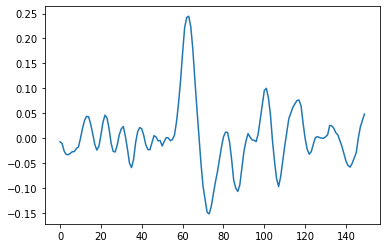

In [359]:
plt.plot(r_cache.get_traces(channel_ids=[1], start_frame=400, end_frame=550)[0])

# The scaling of the data after preprocessing is very different, so using the gain from the set file does not make sense!
# In this case this is probably because of the median filter

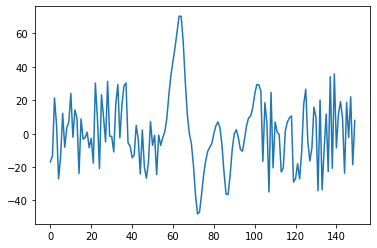

In [360]:
plt.plot(recording.get_traces(channel_ids=[1], start_frame=400, end_frame=550)[0])

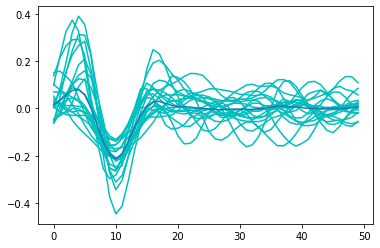

In [140]:
# Show example waveforms and mean waveform for first unit

for i in range(20):
    plt.plot(waveforms[0][i, 0, :], 'c')
plt.plot(np.mean(waveforms[0][:, 0, :], axis=0))

In [141]:
# Waveforms on the binary .X files are in int8, so we need to convert back to it
# Originally, AxonaUnitRecordingExtractor converts from int8 to float32 using the `gain`
# from `recording.get_channel_gains()`
# At a later point though, we may not have this method available to us anymore, and we
# we could instead determine the right `gain` empirically. It might also be possible to
# use the `.set` file, but I would need to know which unit belongs to which channel, since
# gain is saved for each channel, not unit. Actually, it seems that the gain for a given
# tetrode is the same for all channels, so using the `.set` file might be possible.

waveforms[0][0, 0, 0:2]

memmap([-0.04597167, -0.03142679], dtype=float32)

In [142]:
recording_nwb.get_channel_gains()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [143]:
# Read .set file header information

set_file = dir_name / 'axona_sample.set'

header = parse_generic_header(set_file)

In [144]:
# Note that here we need to specify byes_per_samples=2, because the gain in the .set file is based
# on the .bin data. When we compute the gain empirically based on the .X data we obtain a roughly
# similar result (based on a single channel).

bytes_per_sample = 1
gain = 10000

adc_fm = int(header['ADC_fullscale_mv'])
print(adc_fm)

max_value = 2**(8 * bytes_per_sample - 1)
print(max_value)

1000 * adc_fm / (gain * max_value)

1500
128


1.171875

In [195]:
def scale_values(x, maxabs, bound=127):
    '''Scale signal `x` between -`bound` and +`bound`,
    preserves 0 point.
    
    Parameters
    ----------
    x : np.array
    absmax : numeric
        max(|min(x)|, |max(x)|)
    bound : numeric
    
    Return
    ------
    np.array
    '''
    return x / maxabs * bound

In [196]:
def uV_to_int(x, gain):
    '''
    Parameters
    ----------
    x : np.array
    gain : float
    
    Return
    ------
    np.array
    '''
    return x / gain

In [197]:
def int_to_uV(x, gain):
    '''
    Parameters
    ----------
    x : np.array
    gain : float
    
    Return
    ------
    np.array
    '''
    return x * gain

In [325]:
wave = waveforms[0][0, 0, :]
x = wave

In [326]:
bound = 127
maxabs = max(abs(np.array([max(wave), min(wave)])))
print(maxabs)

0.2485281


In [327]:
maxabs = max(abs(np.array([max(wave), min(wave)])))
wv_flt32 = scale_values(wave, maxabs, 127)
wv_int8 = wv_flt32.astype(np.int8)

In [335]:
gains[0] / 1000

array([0.00117187])

In [331]:
maxabs / bound

0.0019569141188944417

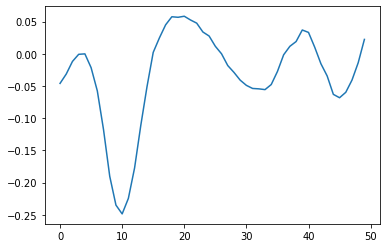

In [328]:
plt.plot(wave)

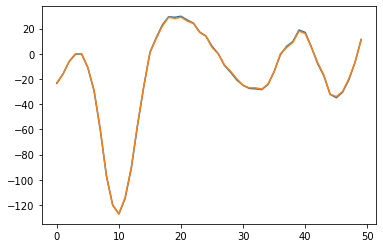

In [329]:
plt.plot(wv_flt32)
plt.plot(wv_int8)

In [330]:
# Convert wv_int8 back to wave (float32, uV)

wave

memmap([-4.59716655e-02, -3.14267948e-02, -1.18867327e-02,
        -8.51369055e-04, -1.52516412e-04, -2.15674788e-02,
        -5.75896502e-02, -1.17732257e-01, -1.90118372e-01,
        -2.34858811e-01, -2.48528093e-01, -2.24426940e-01,
        -1.77180007e-01, -1.11156002e-01, -5.11078313e-02,
         2.15539802e-03,  2.46903282e-02,  4.49373238e-02,
         5.74426055e-02,  5.66299409e-02,  5.82408383e-02,
         5.24550267e-02,  4.75387871e-02,  3.37717682e-02,
         2.75323708e-02,  1.16140656e-02, -5.98585466e-05,
        -1.82659999e-02, -2.89097149e-02, -4.09241617e-02,
        -4.90252078e-02, -5.38289510e-02, -5.44340685e-02,
        -5.56213371e-02, -4.77544963e-02, -2.74660885e-02,
        -1.55911082e-03,  1.15676690e-02,  1.89493429e-02,
         3.68975922e-02,  3.31486017e-02,  1.01742214e-02,
        -1.54932905e-02, -3.43379416e-02, -6.29887283e-02,
        -6.82341456e-02, -5.97973838e-02, -4.08681594e-02,
        -1.39398230e-02,  2.23009363e-02], dtype=float32

In [152]:
wv_int8

array([ -23,  -16,   -6,    0,    0,  -11,  -29,  -60,  -97, -120, -127,
       -114,  -90,  -56,  -26,    1,   12,   22,   29,   28,   29,   26,
         24,   17,   14,    5,    0,   -9,  -14,  -20,  -25,  -27,  -27,
        -28,  -24,  -14,    0,    5,    9,   18,   16,    5,   -7,  -17,
        -32,  -34,  -30,  -20,   -7,   11], dtype=int8)

In [153]:
spike_train = sorting_nwb.get_units_spike_train(unit_ids=[0])
spike_train

[array([  806,  1638,  1854,  2044,  2642,  2929,  4106,  5032,  5982,
         6056,  6711,  7489,  7691,  8229, 10222, 11061, 11961, 13920,
        14137, 16582, 17070, 17403, 17661, 18316, 18751, 18789, 18964,
        20220, 20854, 22096, 24185, 24770, 24788, 25149, 26285, 26382,
        26529, 27031, 27706, 29057, 29884, 30126, 30362, 30739, 31774,
        33709, 34159, 36395, 36676, 37662, 38283, 38612, 39187, 40663,
        41048, 41490, 41602, 42303, 43438, 44502, 44692, 44973, 45147,
        45616, 45747, 45780, 46531, 47303, 49143, 49495, 52031, 55848])]

In [154]:
# Get gains and offsets from recordingextractor

print(dir_name / 'axona_sample.1')
recording = se.AxonaUnitRecordingExtractor(filename=dir_name / 'axona_sample.1', noise_std=15)

channel_ids = recording.get_channel_ids()
channel_idxs = np.array([recording.get_channel_ids().index(ch) for ch in channel_ids])
gains = recording.get_channel_gains()[channel_idxs, None]
offsets = recording.get_channel_offsets()[channel_idxs, None]
_ = [print(g, o) for g, o in zip(gains, offsets)]

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/axona_sample.1
[1.171875] [0.]
[1.171875] [0.]
[1.171875] [0.]
[1.171875] [0.]
[0.5859375] [0.]
[0.5859375] [0.]
[0.5859375] [0.]
[0.5859375] [0.]
[0.78125] [0.]
[0.78125] [0.]
[0.78125] [0.]
[0.78125] [0.]
[0.78125] [0.]
[0.78125] [0.]
[0.78125] [0.]
[0.78125] [0.]


In [155]:
recording.neo_reader._get_channel_gain(bytes_per_sample=1)[0:len(recording.get_channel_ids())]

[1.171875,
 1.171875,
 1.171875,
 1.171875,
 0.5859375,
 0.5859375,
 0.5859375,
 0.5859375,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125]

In [156]:
# ultimately we want to compate the waveforms in spikeextractors that were originally extracted
# from the .bin file (without any addition changes in spikeextractors) with the tetrode file waveforms
# in the .X files to see if our conversion to `int8` makes sense!

from neo import AxonaIO

neoio = AxonaIO(dir_name / 'axona_sample.set')
print(neoio)

waveforms = neoio.get_spike_raw_waveforms(spike_channel_index=0)
print(waveforms.shape)
channel_waves = waveforms[:, 0, :]
print(channel_waves.shape)

# Convert channel_waves from .X file to float32 using gains and offsets from axonaunitrecordingextractor
gain = gains[0]
offset = offsets[0]
channel_waves_flt32 = (channel_waves.astype("float32") * gain + offset).astype("float32")

AxonaIO: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/axona_sample.set
nb_block: 1
nb_segment:  [1]
signal_streams: [stream 0 (chans: 16)]
signal_channels: [1a, 1b, 1c, 1d ... 4a , 4b , 4c , 4d]
spike_channels: [tetrode 1, tetrode 2, tetrode 3, tetrode 4]
event_channels: []

(159, 4, 50)
(159, 50)


In [157]:
neoio._get_channel_gain(bytes_per_sample=1)[0:16]

[1.171875,
 1.171875,
 1.171875,
 1.171875,
 0.5859375,
 0.5859375,
 0.5859375,
 0.5859375,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125]

In [158]:
waveforms

memmap([[[  -7,    2,   18, ...,   33,   26,   15],
         [  -6,   -2,    1, ...,   25,   25,   22],
         [  -2,    3,   14, ...,   30,   24,   14],
         [ -18,   -6,   13, ...,   22,   10,   -3]],

        [[   4,   -3,  -11, ...,  -11,  -10,  -12],
         [  28,   22,    8, ...,   -7,  -10,  -12],
         [  22,   15,    1, ...,  -14,  -15,  -14],
         [  40,   56,   57, ...,   -9,  -15,  -24]],

        [[  15,    6,   -1, ...,  -40,  -25,   -8],
         [  17,   14,    6, ...,  -29,  -29,  -25],
         [  20,   15,    7, ...,  -34,  -24,  -11],
         [   1,  -13,  -27, ...,  -53,  -31,   -5]],

        ...,

        [[ -40,  -71, -108, ...,  -36,  -57,  -71],
         [ -35,  -39,  -43, ...,   14,    0,  -20],
         [ -15,  -17,  -22, ...,    5,  -15,  -46],
         [ -20,  -20,  -26, ...,   12,   -6,  -32]],

        [[   7,    5,    7, ...,    9,    6,    1],
         [  -2,   -7,  -12, ...,  -15,  -13,  -16],
         [  42,   44,   33, ...,   -1,   -

In [159]:
spike_samples = neoio.get_spike_timestamps(spike_channel_index=0)
spike_samples2 = neoio._get_spike_timestamps(block_index=0, seg_index=0, unit_index=0, t_start=0, t_stop=None)
assert np.array_equal(spike_samples, spike_samples2)

# We need to divide the spike_samples by 2, because timestamps are sampled at a higher frequency than 
# data samples (96khz vs 48khz)
spike_samples = (spike_samples / 2).astype(np.int32)
spike_samples[0:10]

array([ 464,  786, 1570, 1632, 1826, 2017, 2228, 2322, 2493, 2634],
      dtype=int32)

In [160]:
traces_channel1 = recording.get_traces(channel_ids=[0], start_frame=0,end_frame=recording.get_num_frames(),
                                       return_scaled=False)
traces_channel1[0, spike_samples[0]-10 : spike_samples[0]+40]

array([ -7.,   2.,  18.,  36.,  49.,  54.,  53.,  51.,  52.,  52.,  44.,
        29.,  17.,  10.,   4.,  -4., -16., -23., -20.,  -7.,  -7.,  21.,
        27.,  27.,  22.,  11.,  -2., -12., -15., -13., -12., -12.,  -7.,
         2.,  11.,  18.,  20.,  16.,   9.,   2.,   0.,   2.,   8.,  14.,
        19.,  25.,  32.,  33.,  26.,  15.])

In [161]:
traces_channel1_flt32 = recording.get_traces(channel_ids=[0], start_frame=spike_samples[0]-10, 
                                             end_frame=spike_samples[0]+40, return_scaled=True)
traces_channel1_flt32

array([[ -8.203125,   2.34375 ,  21.09375 ,  42.1875  ,  57.421875,
         63.28125 ,  62.109375,  59.765625,  60.9375  ,  60.9375  ,
         51.5625  ,  33.984375,  19.921875,  11.71875 ,   4.6875  ,
         -4.6875  , -18.75    , -26.953125, -23.4375  ,  -8.203125,
         -8.203125,  24.609375,  31.640625,  31.640625,  25.78125 ,
         12.890625,  -2.34375 , -14.0625  , -17.578125, -15.234375,
        -14.0625  , -14.0625  ,  -8.203125,   2.34375 ,  12.890625,
         21.09375 ,  23.4375  ,  18.75    ,  10.546875,   2.34375 ,
          0.      ,   2.34375 ,   9.375   ,  16.40625 ,  22.265625,
         29.296875,  37.5     ,  38.671875,  30.46875 ,  17.578125]],
      dtype=float32)

In [162]:
print(gain)

[1.171875]


In [163]:
wave = traces_channel1_flt32[0,:]
print(wave)

maxabs = max(abs(np.array([max(wave), min(wave)])))
wv_flt32 = scale_values(wave, maxabs, 127)
wv_int8 = wv_flt32.astype(np.int8)

print(wv_int8)

wave_backtrans = wv_int8 / bound * maxabs
print(wave_backtrans)

[ -8.203125   2.34375   21.09375   42.1875    57.421875  63.28125
  62.109375  59.765625  60.9375    60.9375    51.5625    33.984375
  19.921875  11.71875    4.6875    -4.6875   -18.75     -26.953125
 -23.4375    -8.203125  -8.203125  24.609375  31.640625  31.640625
  25.78125   12.890625  -2.34375  -14.0625   -17.578125 -15.234375
 -14.0625   -14.0625    -8.203125   2.34375   12.890625  21.09375
  23.4375    18.75      10.546875   2.34375    0.         2.34375
   9.375     16.40625   22.265625  29.296875  37.5       38.671875
  30.46875   17.578125]
[-16   4  42  84 115 127 124 119 122 122 103  68  39  23   9  -9 -37 -54
 -47 -16 -16  49  63  63  51  25  -4 -28 -35 -30 -28 -28 -16   4  25  42
  47  37  21   4   0   4  18  32  44  58  75  77  61  35]
[ -7.97244094   1.99311024  20.92765748  41.85531496  57.30191929
  63.28125     61.78641732  59.29502953  60.7898622   60.7898622
  51.32258858  33.88287402  19.4328248   11.46038386   4.48449803
  -4.48449803 -18.43626969 -26.90698819 -2

In [164]:
empirical_gain = maxabs / bound
print(empirical_gain)

0.4982775590551181


In [165]:
# convert back to int8
# traces_channel1_flt32 = traces.astype("float32") * gains + offsets
# traces_channel1_int8 = (traces_channel1_flt32 - offsets) / gains

traces_channel1_int8 = (traces_channel1_flt32 - offset) / gain
traces_channel1_int8

array([[ -7.,   2.,  18.,  36.,  49.,  54.,  53.,  51.,  52.,  52.,  44.,
         29.,  17.,  10.,   4.,  -4., -16., -23., -20.,  -7.,  -7.,  21.,
         27.,  27.,  22.,  11.,  -2., -12., -15., -13., -12., -12.,  -7.,
          2.,  11.,  18.,  20.,  16.,   9.,   2.,   0.,   2.,   8.,  14.,
         19.,  25.,  32.,  33.,  26.,  15.]])

In [166]:
channel_waves

memmap([[  -7,    2,   18, ...,   33,   26,   15],
        [   4,   -3,  -11, ...,  -11,  -10,  -12],
        [  15,    6,   -1, ...,  -40,  -25,   -8],
        ...,
        [ -40,  -71, -108, ...,  -36,  -57,  -71],
        [   7,    5,    7, ...,    9,    6,    1],
        [ -28,  -29,  -19, ...,   17,   21,   26]], dtype=int8)

In [167]:
wave = traces_channel1_flt32[0,:]
print(wave)

maxabs = max(abs(np.array([max(wave), min(wave)])))
wv_flt32 = scale_values(wave, maxabs, 127)
wv_int8 = wv_flt32.astype(np.int8)

print(wv_int8)

wave_backtrans = wv_int8 / bound * maxabs
print(wave_backtrans)

[ -8.203125   2.34375   21.09375   42.1875    57.421875  63.28125
  62.109375  59.765625  60.9375    60.9375    51.5625    33.984375
  19.921875  11.71875    4.6875    -4.6875   -18.75     -26.953125
 -23.4375    -8.203125  -8.203125  24.609375  31.640625  31.640625
  25.78125   12.890625  -2.34375  -14.0625   -17.578125 -15.234375
 -14.0625   -14.0625    -8.203125   2.34375   12.890625  21.09375
  23.4375    18.75      10.546875   2.34375    0.         2.34375
   9.375     16.40625   22.265625  29.296875  37.5       38.671875
  30.46875   17.578125]
[-16   4  42  84 115 127 124 119 122 122 103  68  39  23   9  -9 -37 -54
 -47 -16 -16  49  63  63  51  25  -4 -28 -35 -30 -28 -28 -16   4  25  42
  47  37  21   4   0   4  18  32  44  58  75  77  61  35]
[ -7.97244094   1.99311024  20.92765748  41.85531496  57.30191929
  63.28125     61.78641732  59.29502953  60.7898622   60.7898622
  51.32258858  33.88287402  19.4328248   11.46038386   4.48449803
  -4.48449803 -18.43626969 -26.90698819 -2

(1, 57600)
[ -8.203125   2.34375   21.09375   42.1875    57.421875  63.28125
  62.109375  59.765625  60.9375    60.9375    51.5625    33.984375
  19.921875  11.71875    4.6875    -4.6875   -18.75     -26.953125
 -23.4375    -8.203125  -8.203125  24.609375  31.640625  31.640625
  25.78125   12.890625  -2.34375  -14.0625   -17.578125 -15.234375
 -14.0625   -14.0625    -8.203125   2.34375   12.890625  21.09375
  23.4375    18.75      10.546875   2.34375    0.         2.34375
   9.375     16.40625   22.265625  29.296875  37.5       38.671875
  30.46875   17.578125]
[ -6   1  17  35  48  53  52  50  51  51  43  28  16   9   3  -3 -15 -22
 -19  -6  -6  20  26  26  21  10  -1 -11 -14 -12 -11 -11  -6   1  10  17
  19  15   8   1   0   1   7  13  18  24  31  32  25  14]
[ -7.08661417   1.18110236  20.07874016  41.33858268  56.69291339
  62.5984252   61.41732283  59.05511811  60.23622047  60.23622047
  50.78740157  33.07086614  18.8976378   10.62992126   3.54330709
  -3.54330709 -17.71653543 -25

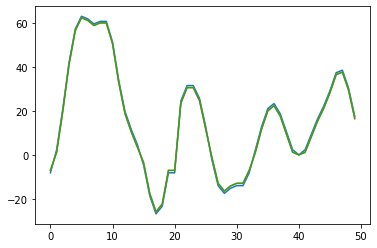

In [178]:
# we should normalize based on the entire signal
traces_channel1 = recording.get_traces(channel_ids=[0], start_frame=0,end_frame=recording.get_num_frames(),
                                       return_scaled=True)
print(traces_channel1.shape)

wave = traces_channel1[0,:]
print(wave[spike_samples[0]-10 : spike_samples[0]+40])

maxabs = max(abs(np.array([max(wave), min(wave)])))
wv_flt32 = scale_values(wave, maxabs, 127)
wv_int8 = wv_flt32.astype(np.int8)

print(wv_int8[spike_samples[0]-10 : spike_samples[0]+40])

wave_backtrans = wv_int8 / bound * maxabs
gain = maxabs / bound
wave_backtrans2 = wv_int8 * gain
print(wave_backtrans[spike_samples[0]-10 : spike_samples[0]+40])

plt.plot(wave[spike_samples[0]-10 : spike_samples[0]+40])
plt.plot(wave_backtrans[spike_samples[0]-10 : spike_samples[0]+40])
plt.plot(wave_backtrans2[spike_samples[0]-10 : spike_samples[0]+40])

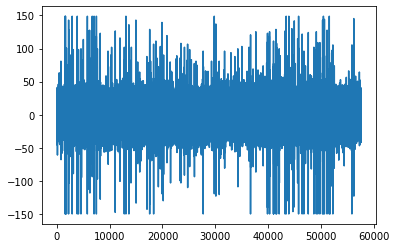

In [169]:
plt.plot(wave)

In [170]:
# IMPORTANT: I need to keep track of `bound` and `maxabs`, otherwise I can never go back to uV from .X
# Is maxabs equivalent to the gain / scaling factor from neo? 
# Check how the scaling factor is used, then
# write my own accordingly. Make sure this doesn't lead to awkward conflicts between `.bin` and `.X` files!

# From spikeextractors extraction_tools check_get_traces_args
#if recording.has_unscaled and return_scaled:
#    channel_idxs = np.array([recording.get_channel_ids().index(ch) for ch in channel_ids])
#    gains = recording.get_channel_gains()[channel_idxs, None]
#    offsets = recording.get_channel_offsets()[channel_idxs, None]
#    traces = (traces.astype("float32") * gains + offsets).astype("float32")

# So we need to be able to get `gains` by calling `recording.get_channel_gains()`

wave_backtrans = wv_int8 / bound * maxabs

In [171]:
gain = maxabs / bound
wave_backtrans2 = wv_int8 * gain

In [172]:
gains

array([[1.171875 ],
       [1.171875 ],
       [1.171875 ],
       [1.171875 ],
       [0.5859375],
       [0.5859375],
       [0.5859375],
       [0.5859375],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ]])

In [173]:
gain

1.1811023622047243

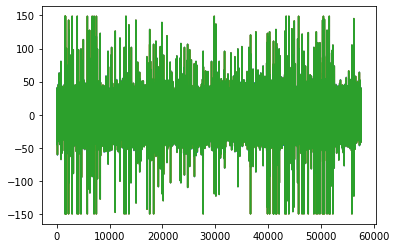

In [174]:
plt.plot(wave)
plt.plot(wave_backtrans)
plt.plot(wave_backtrans2)

In [175]:
wave

array([-10.604283 ,  -0.5503425, -12.034132 , ...,  10.509245 ,
        19.490213 ,  -2.8848197], dtype=float32)

In [188]:
x = wave
print(x[0:4], max(x), min(x))

[ 17.179863     5.091243   -16.353863    -0.32273036] 148.82812 -150.0


In [ ]:
x_norm = x / maxabs * bound

In [ ]:
gain = maxabs / bound

In [190]:
x_norm = x / gain
print(x_norm[0:4])

[ 14.545617     4.3105855  -13.846271    -0.27324504]


In [183]:
maxabs = max(abs(np.array([max(wave), min(wave)])))
wv_flt32_gainset = scale_values(wave, maxabs, 127)
wv_int8_gainset = wv_flt32.astype(np.int8)

array([ 14,   4, -13, ...,  13, -33,   7], dtype=int8)

In [182]:
wv_int8

array([ 14,   4, -13, ...,  13, -33,   7], dtype=int8)

In [ ]:
# Can we determine channel gain from the `.set` file rather than estimating empirically?

wv_int8

gain = maxabs / bound
wave_backtrans2 = wv_int8 * gain

plt.plot(wave)
plt.plot(wave_backtrans)
plt.plot(wave_backtrans2)

In [198]:
gain

1.1811023622047243

In [199]:
gains[0]

array([1.171875])

In [200]:
gains

array([[1.171875 ],
       [1.171875 ],
       [1.171875 ],
       [1.171875 ],
       [0.5859375],
       [0.5859375],
       [0.5859375],
       [0.5859375],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ],
       [0.78125  ]])

In [237]:
st.postprocessing.get_unit_waveforms??

In [242]:
import pandas as pd

df = pd.DataFrame({
    'channel_ids': r_cache.get_channel_ids(),
    'channel_groups': r_cache.get_channel_groups(),
    'tetrode_ids': r_cache.get_channel_groups() + 1
})
df

,channel_ids,channel_groups,tetrode_ids
0,1,0,1
1,2,0,1
2,4,1,2
3,6,1,2
4,7,1,2
5,8,2,3
6,9,2,3
7,10,2,3
8,11,2,3
9,12,3,4


array([1.171875 , 1.171875 , 1.171875 , 1.171875 , 0.5859375, 0.5859375,
       0.5859375, 0.5859375, 0.78125  , 0.78125  , 0.78125  , 0.78125  ,
       0.78125  , 0.78125  , 0.78125  , 0.78125  ])

In [291]:
# add gains to df

df_gain = pd.DataFrame({'gain': gains[:,0],
                        'channel_ids': [i for i in range(16)]})
df_gain

,gain,channel_ids
0,1.171875,0
1,1.171875,1
2,1.171875,2
3,1.171875,3
4,0.585938,4
5,0.585938,5
6,0.585938,6
7,0.585938,7
8,0.781250,8
9,0.781250,9


In [294]:
# add gain to df

df = df.merge(df_gain, how='left', on='channel_ids')

In [295]:
df

,channel_ids,channel_groups,tetrode_ids,gain
0,1,0,1,1.171875
1,2,0,1,1.171875
2,4,1,2,0.585938
3,6,1,2,0.585938
4,7,1,2,0.585938
5,8,2,3,0.781250
6,9,2,3,0.781250
7,10,2,3,0.781250
8,11,2,3,0.781250
9,12,3,4,0.781250


In [254]:
channel_ids = list(df.loc[df['channel_groups'] == 0, 'channel_ids'].values)

In [296]:
list(df.loc[df['channel_groups'] == 0, 'channel_ids'].values)

[1, 2]

In [259]:
channel_ids

[1, 2]

In [260]:
r_cache.get_channel_ids()

[1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [261]:
list(r_cache.get_channel_ids())

[1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [262]:
np.array([list(r_cache.get_channel_ids()).index(ch) for ch in channel_ids])

array([0, 1])

In [272]:
st.postprocessing.get_unit_waveforms??

In [278]:
# retrieve waveforms for tetrode 1 (channel group 0)

waveforms, spk_idxs, chn_idxs = st.postprocessing.get_unit_waveforms(
    r_cache,
    sorting_nwb,
    max_spikes_per_unit=None, 
    grouping_property='group',
    recompute_info=True,
    verbose=True,
    ms_before=ms_before,
    ms_after=ms_after,
    return_idxs=True
)

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:01<00:00,  1.51s/it]


In [279]:
# channel indeces returned by get_unit_waveforms seem to reference what is returned by
# r_cache.get_channel_ids(), so if channel 0 is missing, 0 in chn_idxs would refer to channel 1

chn_idxs

[array([0, 1]),
 array([0, 1]),
 array([2, 3, 4]),
 array([2, 3, 4]),
 array([2, 3, 4]),
 array([2, 3, 4]),
 array([5, 6, 7, 8]),
 array([5, 6, 7, 8]),
 array([5, 6, 7, 8]),
 array([5, 6, 7, 8]),
 array([ 9, 10, 11, 12]),
 array([ 9, 10, 11, 12]),
 array([ 9, 10, 11, 12]),
 array([ 9, 10, 11, 12])]

In [276]:
waveforms[0].shape

(72, 2, 50)

In [277]:
for wf in waveforms:
    print(wf.shape)

(72, 2, 50)
(101, 2, 50)
(59, 3, 50)
(15, 3, 50)
(39, 3, 50)
(51, 3, 50)
(38, 4, 50)
(50, 4, 50)
(47, 4, 50)
(73, 4, 50)
(47, 4, 50)
(42, 4, 50)
(67, 4, 50)
(52, 4, 50)


In [239]:
channel_groups = r_cache.get_channel_groups()
channel_groups

array([0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

In [223]:
itetrode = 0
np.unique(gains[channel_groups[channel_groups == itetrode]])[0]

1.171875

In [230]:
st.postprocessing.get_unit_waveforms??

In [229]:
waveforms[0].shape

(72, 2, 50)

In [299]:
np.unique(chn_idxs[0])

array([0, 1])

In [303]:
ch_id = chn_idxs[0][0]
ch_id

0

In [361]:
wave = waveforms[0]
wave.shape

(72, 2, 50)

In [369]:
max(wave.flatten())

0.45975673

In [371]:
# Since we cannot use the gain from AxonaUnitRecordingExtractor, because preprocessing steps may have 
# re-scaled the signal, we will simply re-scale each unit separatley based on its data.

wave = waveforms[0]
ch_ids = chn_idxs[0]

bound = 127
maxabs = max(abs(np.array([max(wave.flatten()), min(wave.flatten())])))

In [372]:
maxabs

0.5839966

In [391]:
max([abs(max(wave.flatten())), abs(min(wave.flatten()))])

0.41966096

In [394]:
# Check if I ever get values beyong 127 or -128 when using the gain values from the .set file

bound = 127
waveforms_int8 = []
maxabs_list = []
for wave, chn_idxs_wave in zip(waveforms, chn_idxs):
    
    maxabs = max(abs(np.array([max(wave.flatten()), min(wave.flatten())])))
    maxabs_list.append(maxabs)
    
    wave_int8 = np.zeros((wave.shape))
    for i, ch_id in enumerate(chn_idxs_wave):
        
        gain = df.loc[ch_id, 'gain']
        wave_int8[:,i,:] = (scale_values(wave[:,i,:], maxabs, bound)).astype(np.int8)
        
    waveforms_int8.append(wave_int8)

In [397]:
# Do we indeed have max and min values of -127 or +127 now for each waveform?

_ = [print(max(wv_int8.flatten()), min(wv_int8.flatten())) for wv_int8 in waveforms_int8]

99.0 -127.0
127.0 -106.0
127.0 -114.0
111.0 -127.0
104.0 -127.0
97.0 -127.0
125.0 -127.0
125.0 -127.0
126.0 -127.0
113.0 -127.0
127.0 -106.0
127.0 -115.0
124.0 -127.0
127.0 -119.0


48000.0

In [402]:
# Put float to int8 conversion together

# retrieve waveforms (all units)
sampling_rate = r_cache.get_sampling_frequency()
samples_before = int(header['pretrigSamps'])
samples_after = int(header['spikeLockout'])

ms_before = samples_before / (sampling_rate / 1000) + 0.001
ms_after = samples_after / (sampling_rate / 1000) + 0.001

waveforms, spk_idxs, chn_idxs = st.postprocessing.get_unit_waveforms(
    r_cache,
    sorting_nwb,
    max_spikes_per_unit=None, 
    grouping_property='group',
    recompute_info=True,
    verbose=True,
    ms_before=ms_before,
    ms_after=ms_after,
    return_idxs=True
)

# Convert float waveforms to int8
bound = 127
waveforms_int8 = []
maxabs_list = []
for wave, chn_idxs_wave in zip(waveforms, chn_idxs):
    
    maxabs = max(abs(np.array([max(wave.flatten()), min(wave.flatten())])))
    maxabs_list.append(maxabs)
    
    wave_int8 = np.zeros((wave.shape))
    for i, ch_id in enumerate(chn_idxs_wave):
        
        gain = df.loc[ch_id, 'gain']
        wave_int8[:,i,:] = (scale_values(wave[:,i,:], maxabs, bound)).astype(np.int8)
        
    waveforms_int8.append(wave_int8)

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:01<00:00,  1.56s/it]


In [403]:
# Do we indeed have max and min values of -127 or +127 now for each waveform?

_ = [print(max(wv_int8.flatten()), min(wv_int8.flatten())) for wv_int8 in waveforms_int8]

99.0 -127.0
127.0 -106.0
127.0 -114.0
111.0 -127.0
104.0 -127.0
97.0 -127.0
125.0 -127.0
125.0 -127.0
126.0 -127.0
113.0 -127.0
127.0 -106.0
127.0 -115.0
124.0 -127.0
127.0 -119.0


In [408]:
chn_idxs

[array([0, 1]),
 array([0, 1]),
 array([2, 3, 4]),
 array([2, 3, 4]),
 array([2, 3, 4]),
 array([2, 3, 4]),
 array([5, 6, 7, 8]),
 array([5, 6, 7, 8]),
 array([5, 6, 7, 8]),
 array([5, 6, 7, 8]),
 array([ 9, 10, 11, 12]),
 array([ 9, 10, 11, 12]),
 array([ 9, 10, 11, 12]),
 array([ 9, 10, 11, 12])]

In [413]:
unit_ids = np.array(sorting_nwb.get_unit_ids())
print(unit_ids)

group_ids = sorting_nwb.get_units_property(property_name='group')
group_ids = np.array(tetrode_ids)
print(group_ids)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[0 0 1 1 1 1 2 2 2 2 3 3 3 3]


In [426]:
# On the .X file there will be no more unit information, we will write all units from a given
# tetrode for each tetrode channel

spike_samples = sorting_nwb.get_units_spike_train()
for spk_trn in spike_samples:
    print(spk_trn.shape)

(72,)
(101,)
(59,)
(15,)
(39,)
(51,)
(38,)
(50,)
(47,)
(73,)
(47,)
(42,)
(67,)
(52,)


In [427]:
spike_samples

[array([  806,  1638,  1854,  2044,  2642,  2929,  4106,  5032,  5982,
         6056,  6711,  7489,  7691,  8229, 10222, 11061, 11961, 13920,
        14137, 16582, 17070, 17403, 17661, 18316, 18751, 18789, 18964,
        20220, 20854, 22096, 24185, 24770, 24788, 25149, 26285, 26382,
        26529, 27031, 27706, 29057, 29884, 30126, 30362, 30739, 31774,
        33709, 34159, 36395, 36676, 37662, 38283, 38612, 39187, 40663,
        41048, 41490, 41602, 42303, 43438, 44502, 44692, 44973, 45147,
        45616, 45747, 45780, 46531, 47303, 49143, 49495, 52031, 55848]),
 array([  472,  1579,  1823,  2255,  2345,  3132,  3869,  3946,  4678,
         5789,  5810,  6242,  6264,  6410,  6699,  6725,  6938,  7077,
         7256,  8059,  9778,  9799, 10239, 10722, 11103, 11946, 12703,
        12769, 12893, 13086, 13648, 14073, 14483, 14972, 15007, 15302,
        15343, 15679, 15711, 15963, 16459, 16756, 17751, 18986, 19221,
        19597, 19910, 20142, 22564, 22645, 22720, 23303, 24087, 24588,
    

In [428]:
# Getting close to being able to write tetrode files using `write_tetrode` from `BinConverter`
# Remember: Timestamps are at 96 kHz.

tetrode_spikes = {}

for iunit, (unit_spike_samples, unit_waveforms) in enumerate(zip(spike_samples, waveforms_int8)):
    
    for iwave, (spike_sample, spike_waveform) in enumerate(zip(unit_spike_samples, unit_waveforms)):
        
        tetrode_spikes[spike_sample] = spike_waveform

In [435]:
tetrode_filename = dir_name / 'conversion_to_tint' / 'axona_sample.1'
tetrode_filename

PosixPath('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/conversion_to_tint/axona_sample.1')

In [438]:
filepath = tetrode_filename
data = tetrode_spikes
Fs = sampling_rate

In [442]:
filepath.split()

AttributeError: 'PosixPath' object has no attribute 'split'

In [444]:
session_path, session_filename = os.path.split(filepath)
tint_basename = os.path.splitext(session_filename)[0]
set_filename = os.path.join(session_path, '%s.set' % tint_basename)


'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/conversion_to_tint/axona_sample.set'

In [446]:
header = get_set_header(set_filename)
header

'trial_date Sunday, 4 Oct 2020\ntrial_time 11:07:07\nexperimenter Abid\ncomments \nduration 1.2\nsw_version 1.2.2.16\n'

In [447]:
n = len(data)
num_chans = 'num_chans 4'
timebase_head = '\ntimebase %d hz' % (96000)
bp_timestamp = '\nbytes_per_timestamp %d' % (4)
# samps_per_spike = '\nsamples_per_spike %d' % (int(Fs*1e-3))
samps_per_spike = '\nsamples_per_spike %d' % (50)
sample_rate = '\nsample_rate %d hz' % (Fs)
b_p_sample = '\nbytes_per_sample %d' % (1)
# b_p_sample = '\nbytes_per_sample %d' % (4)
spike_form = '\nspike_format t,ch1,t,ch2,t,ch3,t,ch4'
num_spikes = '\nnum_spikes %d' % (n)
start = '\ndata_start'

write_order = [header, num_chans, timebase_head,
               bp_timestamp,
               samps_per_spike, sample_rate, b_p_sample, spike_form, num_spikes, start]


In [448]:
write_order

['trial_date Sunday, 4 Oct 2020\ntrial_time 11:07:07\nexperimenter Abid\ncomments \nduration 1.2\nsw_version 1.2.2.16\n',
 'num_chans 4',
 '\ntimebase 96000 hz',
 '\nbytes_per_timestamp 4',
 '\nsamples_per_spike 50',
 '\nsample_rate 48000 hz',
 '\nbytes_per_sample 1',
 '\nspike_format t,ch1,t,ch2,t,ch3,t,ch4',
 '\nnum_spikes 712',
 '\ndata_start']

In [449]:
spike_times = np.asarray(sorted(data.keys()))

# the spike times are repeated for each channel so lets tile this
spike_times = np.tile(spike_times, (4, 1))
spike_times = spike_times.flatten(order='F')

spike_values = np.asarray([value for (key, value) in sorted(data.items())])

In [452]:
spike_times

array([   94,    94,    94, ..., 57495, 57495, 57495])

In [ ]:
def write_tetrode(filepath, data, Fs):

    session_path, session_filename = os.path.split(filepath)
    tint_basename = os.path.splitext(session_filename)[0]
    set_filename = os.path.join(session_path, '%s.set' % tint_basename)

    n = len(data)

    header = get_set_header(set_filename)

    with open(filepath, 'w') as f:
        num_chans = 'num_chans 4'
        timebase_head = '\ntimebase %d hz' % (96000)
        bp_timestamp = '\nbytes_per_timestamp %d' % (4)
        # samps_per_spike = '\nsamples_per_spike %d' % (int(Fs*1e-3))
        samps_per_spike = '\nsamples_per_spike %d' % (50)
        sample_rate = '\nsample_rate %d hz' % (Fs)
        b_p_sample = '\nbytes_per_sample %d' % (1)
        # b_p_sample = '\nbytes_per_sample %d' % (4)
        spike_form = '\nspike_format t,ch1,t,ch2,t,ch3,t,ch4'
        num_spikes = '\nnum_spikes %d' % (n)
        start = '\ndata_start'

        write_order = [header, num_chans, timebase_head,
                       bp_timestamp,
                       samps_per_spike, sample_rate, b_p_sample, spike_form, num_spikes, start]

        f.writelines(write_order)

    # rearranging the data to have a flat array of t1, waveform1, t2, waveform2, t3, waveform3, etc....
    spike_times = np.asarray(sorted(data.keys()))

    # the spike times are repeated for each channel so lets tile this
    spike_times = np.tile(spike_times, (4, 1))
    spike_times = spike_times.flatten(order='F')

    spike_values = np.asarray([value for (key, value) in sorted(data.items())])

    # this will create a (n_samples, n_channels, n_samples_per_spike) => (n, 4, 50) sized matrix, we will create a
    # matrix of all the samples and channels going from ch1 -> ch4 for each spike time
    # time1 ch1_data
    # time1 ch2_data
    # time1 ch3_data
    # time1 ch4_data
    # time2 ch1_data
    # time2 ch2_data
    # .
    # .
    # .

    spike_values = spike_values.reshape((n * 4, 50))  # create the 4nx50 channel data matrix

    # make the first column the time values
    spike_array = np.hstack((spike_times.reshape(len(spike_times), 1), spike_values))

    data = None
    spike_times = None
    spike_values = None

    spike_n = spike_array.shape[0]

    t_packed = struct.pack('>%di' % spike_n, *spike_array[:, 0].astype(int))
    spike_array = spike_array[:, 1:]  # removing time data from this matrix to save memory

    spike_data_pack = struct.pack('<%db' % (spike_n*50), *spike_array.astype(int).flatten())

    spike_array = None

    # now we need to combine the lists by alternating

    comb_list = [None] * (2*spike_n)
    comb_list[::2] = [t_packed[i:i + 4] for i in range(0, len(t_packed), 4)]  # breaks up t_packed into a list,
    # each timestamp is one 4 byte integer
    comb_list[1::2] = [spike_data_pack[i:i + 50] for i in range(0, len(spike_data_pack), 50)]  # breaks up spike_data_
    # pack and puts it into a list, each spike is 50 one byte integers

    t_packed = None
    spike_data_pack = None

    write_order = []
    with open(filepath, 'rb+') as f:

        write_order.extend(comb_list)
        write_order.append(bytes('\r\ndata_end\r\n', 'utf-8'))

        f.seek(0, 2)
        f.writelines(write_order)

In [436]:
write_tetrode(tetrode_filename, tetrode_spikes, sampling_rate)

/home/sbuergers/spikeinterface/spikeinterface_new_api/venv/lib/python3.8/site-packages/numpy-1.20.3-py3.8-linux-x86_64.egg/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: cannot reshape array of size 712 into shape (2848,50)

## Convert recording extractor to tetrode files (.X)

In [23]:
from BinConverter.core.ConvertTetrode import write_tetrode
from BinConverter.core.readBin import (
    get_bin_data, get_raw_pos, get_channel_from_tetrode, get_active_tetrode, get_active_eeg
)
from BinConverter.core.Tint_Matlab import int16toint8

from spikeextractors.extractors.axonaunitrecordingextractor import AxonaUnitRecordingExtractor

import pandas as pd

In [43]:
def parse_generic_header(filename):
    """
    Given a binary file with phrases and line breaks, enters the
    first word of a phrase as dictionary key and the following
    string (without linebreaks) as value. Returns the dictionary.
    """
    header = {}
    with open(filename, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                break
            line = bin_line.decode('cp1252').replace('\r\n', '').replace('\r', '').strip()
            parts = line.split(' ')
            key = parts[0]
            value = ' '.join(parts[1:])
            header[key] = value
            
    return header

In [44]:
def get_channel_from_tetrode(tetrode):
    """
    This function will take the tetrode number and return the Axona
    channel numbers, i.e. Tetrode 1 = Ch0-Ch3, Tetrode 2 = Ch4-Ch7, etc.
    """
    return np.arange(0, 4) + 4 * (int(tetrode) - 1)

In [45]:
set_file = dir_name / 'axona_sample.set'
set_filename = set_file
print(set_file)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/axona_sample.set


In [46]:
re = AxonaUnitRecordingExtractor(filename=set_file)

In [47]:
re.neo_reader

AxonaRawIO: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin/axona_sample
nb_block: 1
nb_segment:  [1]
signal_streams: [stream 0 (chans: 16)]
signal_channels: [1a, 1b, 1c, 1d ... 4a , 4b , 4c , 4d]
spike_channels: [tetrode 1, tetrode 2, tetrode 3, tetrode 4]
event_channels: []

In [48]:
dir_name

PosixPath('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint_no_bin')

In [49]:
header = parse_generic_header(set_file)

In [50]:
pre_spike_samples = int(header['pretrigSamps'])
post_spike_samples = int(header['spikeLockout'])
rejstart = int(header['rejstart'])
rejthreshtail = int(header['rejthreshtail'])
rejthreshupper = int(header['rejthreshupper'])
rejthreshlower = int(header['rejthreshlower'])

print(pre_spike_samples)
print(post_spike_samples)
print(rejstart)
print(rejthreshtail)
print(rejthreshupper)
print(rejthreshlower)

10
40
30
43
100
-100


In [51]:
r_cache

In [52]:
tetrode = 1
set_file.stem + '.{}'.format(tetrode)

'axona_sample.1'

In [53]:
tetrode_channels = get_channel_from_tetrode(tetrode)

In [54]:
get_bin_data??

Object `get_bin_data` not found.


In [55]:
tetrode

1

In [56]:
import contextlib
import mmap

def get_bin_data(bin_filename, channels=None, tetrode=None):
    """This function will be used to acquire the actual lfp data given the .bin filename,
    and the tetrode or channels (from 1-64) that you want to get"""

    if tetrode is not None:
        channels = get_channel_from_tetrode(tetrode)
    else:
        channels = np.array(channels)  # just in case it isn't an np.array

    bytes_per_iteration = 432

    with open(bin_filename, 'rb') as f:
        # pass
        with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as m:
            num_iterations = int(len(m)/bytes_per_iteration)

            data = np.ndarray((num_iterations,), (np.int16, (1,192)), m, 32, (bytes_per_iteration,)).reshape((-1, 1)).flatten()
            data = samples_to_array(data, channels=channels.tolist())

    return data

def samples_to_array(A, channels=[]):
    """This will take data matrix A, and convert it into a numpy array, there are three samples of
    64 channels in this matrix, however their channels do need to be re-mapped"""

    if channels == []:
        channels = np.arange(64) + 1
    else:
        channels = np.asarray(channels)

    A = np.asarray(A)

    sample_num = int(len(A) / 64)  # get the sample numbers

    sample_array = np.zeros((len(channels), sample_num))  # creating a 64x3 array of zeros (64 channels, 3 samples)

    for i, channel in enumerate(channels):
        sample_array[i, :] = A[get_sample_indices(channel, sample_num)]

    return sample_array

def get_sample_indices(channel_number, samples):
    remap_channel = get_remap_chan(channel_number)

    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)

    # return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)

def get_remap_chan(chan_num):
    """There is re-mapping, thus to get the correct channel data, you need to incorporate re-mapping
    input will be a channel from 1 to 64, and will return the remapped channel"""

    remap_channels = np.array([32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5,
                               6, 7, 40, 41, 42, 43, 44, 45, 46, 47, 8, 9, 10, 11,
                               12, 13, 14, 15, 48, 49, 50, 51, 52, 53, 54, 55, 16, 17,
                               18, 19, 20, 21, 22, 23, 56, 57, 58, 59, 60, 61, 62, 63,
                               24, 25, 26, 27, 28, 29, 30, 31])

    return remap_channels[chan_num - 1]

In [57]:
bin_filename = Path('/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/sample_bin_to_tint/axona_sample.bin')
data = get_bin_data(bin_filename, tetrode=tetrode)

In [58]:
data.shape

(4, 57600)

In [59]:
data

array([[  3574.,   -230.,      0., ...,      0.,      0.,      0.],
       [  3682.,  -3870.,      0., ..., -13700., -14410., -11876.],
       [  1714.,   -188.,      0., ...,  -9006.,  -9980.,  -9502.],
       [ 10480.,   5308.,      0., ...,  -8460.,  -7266.,  -4906.]])

In [60]:
from neo import AxonaIO

In [61]:
neoio = AxonaIO(bin_filename)

In [62]:
bin_data_neo = neoio.get_analogsignal_chunk(channel_indexes=[12, 13, 14, 15]).T

In [63]:
bin_data_neo

array([[ -7572,  -1930,      0, ..., -26920, -22956, -17398],
       [ -5500,   -206,      0, ..., -18238, -17952, -15410],
       [   798,  -9238,      0, ..., -17090, -13344,  -8568],
       [  2378,  -6200,      0, ..., -17912, -15948, -11356]], dtype=int16)

In [64]:
tet1_data_neo = neoio.get_spike_raw_waveforms()

In [65]:
tet1_data_neo

memmap([[[  -7,    2,   18, ...,   33,   26,   15],
         [  -6,   -2,    1, ...,   25,   25,   22],
         [  -2,    3,   14, ...,   30,   24,   14],
         [ -18,   -6,   13, ...,   22,   10,   -3]],

        [[   4,   -3,  -11, ...,  -11,  -10,  -12],
         [  28,   22,    8, ...,   -7,  -10,  -12],
         [  22,   15,    1, ...,  -14,  -15,  -14],
         [  40,   56,   57, ...,   -9,  -15,  -24]],

        [[  15,    6,   -1, ...,  -40,  -25,   -8],
         [  17,   14,    6, ...,  -29,  -29,  -25],
         [  20,   15,    7, ...,  -34,  -24,  -11],
         [   1,  -13,  -27, ...,  -53,  -31,   -5]],

        ...,

        [[ -40,  -71, -108, ...,  -36,  -57,  -71],
         [ -35,  -39,  -43, ...,   14,    0,  -20],
         [ -15,  -17,  -22, ...,    5,  -15,  -46],
         [ -20,  -20,  -26, ...,   12,   -6,  -32]],

        [[   7,    5,    7, ...,    9,    6,    1],
         [  -2,   -7,  -12, ...,  -15,  -13,  -16],
         [  42,   44,   33, ...,   -1,   -

In [66]:
fraw = 3682
f = 4314.84375  # should be 3682

In [48]:
bin(fraw)

'0b111001100010'

In [49]:
bin(f)

TypeError: 'float' object cannot be interpreted as an integer

In [50]:
traces * 1000

NameError: name 'traces' is not defined

In [51]:
type(data[1,1])

numpy.float64

In [52]:
df = pd.DataFrame({
    'channel_ids': r_cache.get_channel_ids(),
    'channel_groups': r_cache.get_channel_groups(),
    'tetrode_ids': r_cache.get_channel_groups() + 1
})
df

,channel_ids,channel_groups,tetrode_ids
0,1,0,1
1,2,0,1
2,4,1,2
3,6,1,2
4,7,1,2
5,8,2,3
6,9,2,3
7,10,2,3
8,11,2,3
9,12,3,4


In [53]:
tetrode_channels = df.loc[df['tetrode_ids'] == tetrode, 'channel_ids'].values + 1
tetrode_channels

array([2, 3])

In [54]:
tetrode_channels-1

array([1, 2])

In [55]:
# A tetrode file expects 4 channels. Fill missing channels with zeros.

traces = np.zeros((4, r_cache.get_num_frames()))
traces[tetrode_channels-1, :] = r_cache.get_traces(channel_ids=tetrode_channels-1)
traces.shape

(4, 57600)

In [56]:
r_cache.get_traces?

In [57]:
tetrode

1

In [58]:
tetrode_channels

array([2, 3])

In [59]:
tetrode = int(tetrode)

tetrode_filename = save_dir / Path(set_file.stem + '.{}'.format(tetrode))

tetrode_channels = df.loc[df['tetrode_ids'] == tetrode, 'channel_ids'].values + 1

traces = np.zeros((4, r_cache.get_num_frames()))
traces[(tetrode_channels-1) % 4, :] = r_cache.get_traces(channel_ids=tetrode_channels-1)

In [60]:
Fs = r_cache.get_sampling_frequency()
active_tetrodes = np.unique(r_cache.get_channel_groups()) + 1

pre_spike_samples = int(header['pretrigSamps'])
post_spike_samples = int(header['spikeLockout'])
rejstart = int(header['rejstart'])
rejthreshtail = int(header['rejthreshtail'])
rejthreshupper = int(header['rejthreshupper'])
rejthreshlower = int(header['rejthreshlower'])

df = pd.DataFrame({
    'channel_ids': r_cache.get_channel_ids(),
    'channel_groups': r_cache.get_channel_groups(),
    'tetrode_ids': r_cache.get_channel_groups() + 1
})

for tetrode in active_tetrodes:

    tetrode = int(tetrode)
    
    tetrode_filename = save_dir / Path(set_file.stem + '.{}'.format(tetrode))
    
    tetrode_channels = df.loc[df['tetrode_ids'] == tetrode, 'channel_ids'].values + 1
    
    traces = np.zeros((4, r_cache.get_num_frames()))
    traces[(tetrode_channels - 1) % 4, :] = r_cache.get_traces(channel_ids=tetrode_channels-1)

    n_samples = traces.shape[1]

    # create a time array that represents the 48kHz sampled data times
    t = np.arange(0, n_samples) / Fs  # creates a time array of the signal starting from 0 (in seconds)

    

In [61]:
def get_spikes(data, threshold):
    all_spikes = np.array([])

    for i, channel_data in enumerate(data):
        spike_indices = np.where(channel_data >= threshold[i])[0]

        if len(spike_indices) == 0:
            continue

        spike_indices = find_consec(spike_indices)

        spike_indices = np.asarray([value[0] for value in spike_indices])

        if len(all_spikes) == 0:
            # this is the first iteration of the tetrode, no need to sort
            unadded_spikes = spike_indices
        else:
            idx = matching_ind(all_spikes, spike_indices)
            if len(idx) == 0:
                unadded_spikes = spike_indices
            else:
                unadded_spikes = np.setdiff1d(spike_indices, all_spikes[idx])

        if len(all_spikes) != 0:
            all_spikes = np.sort(np.concatenate((all_spikes, unadded_spikes)))
            unadded_spikes = None
        else:
            all_spikes = np.array(unadded_spikes)

    return all_spikes

def find_consec(data):
    '''finds the consecutive numbers and outputs as a list'''
    consecutive_values = []  # a list for the output
    current_consecutive = [data[0]]

    if len(data) == 1:
        return [[data[0]]]

    for index in range(1, len(data)):

        if data[index] == data[index - 1] + 1:
            current_consecutive.append(data[index])

            if index == len(data) - 1:
                consecutive_values.append(current_consecutive)

        else:
            consecutive_values.append(current_consecutive)
            current_consecutive = [data[index]]

            if index == len(data) - 1:
                consecutive_values.append(current_consecutive)
    return consecutive_values

def matching_ind(haystack, needle):
    idx = np.searchsorted(haystack, needle)
    mask = idx < haystack.size
    mask[mask] = haystack[idx[mask]] == needle[mask]
    idx = idx[mask]
    return idx

def validate_spikes(tetrode, spikes, data, t, pre_spike_samples=10, post_spike_samples=40, rejstart=30,
                    rejthreshtail=43, rejthreshupper=100, rejthreshlower=-100):
    latest_spike = None

    spike_count = 0
    percentage_values = [int(value) for value in np.rint(np.linspace(0, len(spikes), num=21)).tolist()]

    n_max = data.shape[1]

    tetrode_spikes = {}

    for spike in sorted(spikes):
        # iterate through each spike and validate to ensure no spikes occur at the same time or within the
        # refractory period

        spike_count += 1

        if spike_count in percentage_values:
            pass

        if spike - pre_spike_samples + 1 < 0:
            continue

        elif spike + post_spike_samples >= n_max:
            continue

        if latest_spike is not None:
            if spike != latest_spike:
                if spike in spike_refractory:
                    # ensures no overlapping spikes
                    continue
        else:
            pass

        latest_spike = spike
        spike_refractory = list(np.arange(spike + 1, spike + post_spike_samples + 1))

        # spike_time = t[int(spike)]
        spike_time = t[int(spike)]

        # waveform_indices = np.where((t>=spike_time-250/1e6) & (t<=spike_time+850/1e6))[0]  # too slow
        waveform_indices = np.arange(spike - pre_spike_samples + 1, spike + post_spike_samples + 1).astype(int)

        # spike_t = t[waveform_indices] - spike_time  # making the times from -200 us to 800 us

        # spike_waveform = np.zeros((len(tetrode_channels), 50))

        spike_waveform = data[:, waveform_indices]

        spike_time = spike_time * 96000  # multiply it by the timebase to get the frame count

        spike_waveform = np.rint(spike_waveform)

        # artifact rejection

        if sum(spike_waveform[:, rejstart:].flatten() > rejthreshtail) > 0:
            # this is 33% above baseline (0)
            continue

        # check if the first sample is well above or well below baseline
        elif sum(spike_waveform[:, 0].flatten() > rejthreshupper) > 0:
            # the first sample is >100
            continue

        elif sum(spike_waveform[:, 0].flatten() < rejthreshlower) > 0:
            # or < -100
            continue

        tetrode_spikes[spike_time] = spike_waveform

        # latest_spike = spike
        # spike_refractory = list(np.arange(spike + 1, spike + post_spike_samples + 1))

    return tetrode_spikes

In [62]:
tetrode_channels

array([13, 14, 15, 16])

In [63]:
threshold = 3

tetrode_spikes = {}  # creates an empty dictionary to hold the spike times
# for each tetrode, find the spikes

k = 0

# data = int16toint8(data)  # converting the data into int8

tetrode_thresholds = []
for channel_index, channel in enumerate(tetrode_channels):
    k += 1
    '''
    Auto thresholding technique incorporated by:
    Quian Quiroga in 2014 - Unsupervised Spike Detection and Sorting with Wavelets and
    Superparamagnetic Clustering
    Thr = 4*sigma, sigma = median(abs(x)/0.6745)
    '''
    standard_deviations = float(threshold)

    sigma_n = np.median(np.divide(np.abs(data[channel_index, :]), 0.6745))
    # threshold = sigma_n / channel_max
    # threshold = standard_deviations * sigma_n
    tetrode_thresholds.append(standard_deviations * sigma_n)

valid_spikes = get_spikes(data, tetrode_thresholds)

# threshold is done in 16 bit values, but the rejection is done in 8bit, so we convert here
# data = int16toint8(data)  # converting the data into int8

data_int16 = int16toint8(data)  # converting the

In [64]:
tetrode_thresholds

[0.0, 20993.32839140104, 15389.177168272796, 16474.425500370642]

In [65]:
tetrode_ids = sorting_nwb.get_units_property(property_name='group')
tetrode_ids = np.array(tetrode_ids)

unit_ids = np.array(sorting_nwb.get_unit_ids())
spike_train = sorting_nwb.get_units_spike_train(unit_ids=unit_ids[tetrode_ids==3])

sorted_spike_train = np.sort(np.concatenate(spike_train))

sorted_spike_train

array([  126,  1386,  1466,  1495,  1697,  1714,  1735,  2635,  2803,
        2824,  2838,  2923,  2942,  4677,  4691,  4708,  5145,  5166,
        5239,  5261,  5784,  5903,  5924,  6413,  6442,  6699,  6712,
        6732,  6950,  7065,  7080,  7102,  7219,  7260,  8222,  8297,
        8894,  8915,  9690,  9709,  9727, 10221, 10247, 10731, 10875,
       11169, 11204, 11386, 11803, 11818, 11958, 11980, 12689, 12702,
       12883, 12898, 12911, 14247, 14276, 14487, 14967, 15129, 15144,
       15420, 15437, 15664, 15682, 16586, 16628, 16651, 16670, 16760,
       16781, 16794, 16824, 16838, 16862, 17386, 17403, 17426, 17759,
       18324, 18343, 18756, 19596, 19614, 19629, 19820, 19833, 19900,
       20139, 20689, 20703, 21325, 21338, 21469, 21482, 21526, 21540,
       22095, 22371, 22392, 22712, 22744, 23041, 23073, 23564, 23804,
       23819, 23835, 23987, 24009, 24127, 24441, 25212, 25374, 25392,
       25417, 25462, 25482, 26015, 26368, 26382, 27043, 27059, 27746,
       27762, 29277,

In [66]:
valid_spikes

array([    0,     2,   464,   584,   627,   691,   751,   787,   788,
        1021,  1088,  1150,  1230,  1238,  1571,  1583,  1632,  1644,
        1826,  2228,  2238,  2322,  2326,  2377,  2634,  2635,  2905,
        2911,  2912,  3118,  3277,  3297,  3653,  3752,  3785,  3787,
        3872,  3926,  4103,  4352,  4353,  4364,  4577,  4673,  4674,
        4934,  4935,  5024,  5025,  5165,  5232,  5233,  5568,  5569,
        5781,  5784,  5785,  5974,  5976,  6019,  6208,  6260,  6410,
        6411,  6706,  6708,  6768,  6788,  6982,  6983,  7061,  7064,
        7255,  7256,  7482,  7494,  7601,  7686,  7687,  7837,  8173,
        8222,  8223,  8435,  8437,  8464,  8465,  8655,  8755,  8756,
        9357,  9366,  9557,  9696, 10217, 10376, 10723, 10844, 10869,
       10870, 11066, 11455, 11456, 11954, 11955, 12441, 12444, 12451,
       12454, 12677, 12775, 13078, 13087, 13642, 13643, 13644, 14112,
       14113, 14241, 14242, 14483, 14484, 14502, 14621, 14681, 14682,
       14850, 14853,

In [67]:
traces

array([[ 0.00442661, -0.00972959, -0.01101197, ..., -0.02006962,
        -0.00963475, -0.00524077],
       [-0.00532733, -0.013263  , -0.00653222, ..., -0.00630658,
        -0.00487059, -0.00842494],
       [ 0.00252745, -0.0046536 , -0.00752856, ..., -0.03252275,
        -0.01737364, -0.00533893],
       [-0.00476253, -0.01768241, -0.01526715, ..., -0.02812541,
        -0.03498014, -0.04006043]])

In [68]:
data_int16

array([[ 13,   0,   0, ...,   0,   0,   0],
       [ 14, -15,   0, ..., -53, -56, -46],
       [  6,   0,   0, ..., -35, -38, -37],
       [ 40,  20,   0, ..., -33, -28, -19]])

In [69]:
data

array([[  3574.,   -230.,      0., ...,      0.,      0.,      0.],
       [  3682.,  -3870.,      0., ..., -13700., -14410., -11876.],
       [  1714.,   -188.,      0., ...,  -9006.,  -9980.,  -9502.],
       [ 10480.,   5308.,      0., ...,  -8460.,  -7266.,  -4906.]])

In [70]:
valid_spikes

array([    0,     2,   464,   584,   627,   691,   751,   787,   788,
        1021,  1088,  1150,  1230,  1238,  1571,  1583,  1632,  1644,
        1826,  2228,  2238,  2322,  2326,  2377,  2634,  2635,  2905,
        2911,  2912,  3118,  3277,  3297,  3653,  3752,  3785,  3787,
        3872,  3926,  4103,  4352,  4353,  4364,  4577,  4673,  4674,
        4934,  4935,  5024,  5025,  5165,  5232,  5233,  5568,  5569,
        5781,  5784,  5785,  5974,  5976,  6019,  6208,  6260,  6410,
        6411,  6706,  6708,  6768,  6788,  6982,  6983,  7061,  7064,
        7255,  7256,  7482,  7494,  7601,  7686,  7687,  7837,  8173,
        8222,  8223,  8435,  8437,  8464,  8465,  8655,  8755,  8756,
        9357,  9366,  9557,  9696, 10217, 10376, 10723, 10844, 10869,
       10870, 11066, 11455, 11456, 11954, 11955, 12441, 12444, 12451,
       12454, 12677, 12775, 13078, 13087, 13642, 13643, 13644, 14112,
       14113, 14241, 14242, 14483, 14484, 14502, 14621, 14681, 14682,
       14850, 14853,

In [ ]:
# --------------------------------------Write Tetrode Data----------------------------------------

Fs = get_Fs(set_filename)  # read the sampling frequency from the .set file, most like 48k

active_tetrodes = get_active_tetrode(set_filename)

# converts the data one tetrode at a time so we can eliminate memory errors

pre_spike_samples = int(get_setfile_parameter('pretrigSamps', set_filename))
post_spike_samples = int(get_setfile_parameter('spikeLockout', set_filename))
rejstart = int(get_setfile_parameter('rejstart', set_filename))
rejthreshtail = int(get_setfile_parameter('rejthreshtail', set_filename))
rejthreshupper = int(get_setfile_parameter('rejthreshupper', set_filename))
rejthreshlower = int(get_setfile_parameter('rejthreshlower', set_filename))

for tetrode in active_tetrodes:

    tetrode = int(tetrode)
    # check if this tetrode exists already

    tetrode_filename = os.path.join(directory, '%s.%d' % (tint_basename, tetrode))
    if os.path.exists(tetrode_filename):
        continue

    tetrode_channels = get_channel_from_tetrode(tetrode)  # get the channels (from range of 1->64)

    data = get_bin_data(bin_filename, tetrode=tetrode)  # 16bit, get data associated with the tetrode

    # converting data to uV

    n_samples = data.shape[1]
    # create a time array that represents the 48kHz sampled data times
    t = np.arange(0, n_samples) / Fs  # creates a time array of the signal starting from 0 (in seconds)

    if not os.path.exists(tetrode_filename):

        # ---------------------------Find the spikes in the unit data --------------------------------------

        tetrode_spikes = {}  # creates an empty dictionary to hold the spike times
        # for each tetrode, find the spikes

        k = 0

        # data = int16toint8(data)  # converting the data into int8

        tetrode_thresholds = []
        for channel_index, channel in enumerate(tetrode_channels):
            k += 1
            '''
            Auto thresholding technique incorporated by:
            Quian Quiroga in 2014 - Unsupervised Spike Detection and Sorting with Wavelets and
            Superparamagnetic Clustering
            Thr = 4*sigma, sigma = median(abs(x)/0.6745)
            '''
            standard_deviations = float(threshold)

            sigma_n = np.median(np.divide(np.abs(data[channel_index, :]), 0.6745))
            # threshold = sigma_n / channel_max
            # threshold = standard_deviations * sigma_n
            tetrode_thresholds.append(standard_deviations * sigma_n)

        valid_spikes = get_spikes(data, tetrode_thresholds)

        # threshold is done in 16 bit values, but the rejection is done in 8bit, so we convert here
        # data = int16toint8(data)  # converting the data into int8

        data = int16toint8(data)  # converting the data into int8

        tetrode_spikes = validate_spikes(tetrode, valid_spikes, data, t, pre_spike_samples,
                                         post_spike_samples, rejstart, rejthreshtail, rejthreshupper,
                                         rejthreshlower)

        # write the tetrode data to create the .N file
        write_tetrode(tetrode_filename, tetrode_spikes, Fs)
    else:
        pass

    data = None
    tetrode_spikes = None
    valid_spikes = None

In [ ]:
import os
from .conversion_utils import get_set_header
import numpy as np
import struct


def write_tetrode(filepath, data, Fs):

    session_path, session_filename = os.path.split(filepath)
    tint_basename = os.path.splitext(session_filename)[0]
    set_filename = os.path.join(session_path, '%s.set' % tint_basename)

    n = len(data)

    header = get_set_header(set_filename)

    with open(filepath, 'w') as f:
        num_chans = 'num_chans 4'
        timebase_head = '\ntimebase %d hz' % (96000)
        bp_timestamp = '\nbytes_per_timestamp %d' % (4)
        # samps_per_spike = '\nsamples_per_spike %d' % (int(Fs*1e-3))
        samps_per_spike = '\nsamples_per_spike %d' % (50)
        sample_rate = '\nsample_rate %d hz' % (Fs)
        b_p_sample = '\nbytes_per_sample %d' % (1)
        # b_p_sample = '\nbytes_per_sample %d' % (4)
        spike_form = '\nspike_format t,ch1,t,ch2,t,ch3,t,ch4'
        num_spikes = '\nnum_spikes %d' % (n)
        start = '\ndata_start'

        write_order = [header, num_chans, timebase_head,
                       bp_timestamp,
                       samps_per_spike, sample_rate, b_p_sample, spike_form, num_spikes, start]

        f.writelines(write_order)

    # rearranging the data to have a flat array of t1, waveform1, t2, waveform2, t3, waveform3, etc....
    spike_times = np.asarray(sorted(data.keys()))

    # the spike times are repeated for each channel so lets tile this
    spike_times = np.tile(spike_times, (4, 1))
    spike_times = spike_times.flatten(order='F')

    spike_values = np.asarray([value for (key, value) in sorted(data.items())])

    # this will create a (n_samples, n_channels, n_samples_per_spike) => (n, 4, 50) sized matrix, we will create a
    # matrix of all the samples and channels going from ch1 -> ch4 for each spike time
    # time1 ch1_data
    # time1 ch2_data
    # time1 ch3_data
    # time1 ch4_data
    # time2 ch1_data
    # time2 ch2_data
    # .
    # .
    # .

    spike_values = spike_values.reshape((n * 4, 50))  # create the 4nx50 channel data matrix

    # make the first column the time values
    spike_array = np.hstack((spike_times.reshape(len(spike_times), 1), spike_values))

    data = None
    spike_times = None
    spike_values = None

    spike_n = spike_array.shape[0]

    t_packed = struct.pack('>%di' % spike_n, *spike_array[:, 0].astype(int))
    spike_array = spike_array[:, 1:]  # removing time data from this matrix to save memory

    spike_data_pack = struct.pack('<%db' % (spike_n*50), *spike_array.astype(int).flatten())

    spike_array = None

    # now we need to combine the lists by alternating

    comb_list = [None] * (2*spike_n)
    comb_list[::2] = [t_packed[i:i + 4] for i in range(0, len(t_packed), 4)]  # breaks up t_packed into a list,
    # each timestamp is one 4 byte integer
    comb_list[1::2] = [spike_data_pack[i:i + 50] for i in range(0, len(spike_data_pack), 50)]  # breaks up spike_data_
    # pack and puts it into a list, each spike is 50 one byte integers

    t_packed = None
    spike_data_pack = None

    write_order = []
    with open(filepath, 'rb+') as f:

        write_order.extend(comb_list)
        write_order.append(bytes('\r\ndata_end\r\n', 'utf-8'))

        f.seek(0, 2)
        f.writelines(write_order)

In [220]:
def write_to_tetrode_files(sorting_extractor, save_dir):
    '''Given a sorting extractor object create .X (tetrode) files.
    
    Parameters
    ----------
    sorting_extractor : spikeextractors.SortingExtractor
    save_dir : str or Path
        Directory where to save the output
    '''
    # TODO ...
    pass

In [232]:
def write_to_tint(sorting_extractor, filename):
    '''Given a sorting extractor object, write appropriate data
    to TINT format (from Axona). Will therefore create .X (tetrode),
    .cut and .clu (spike sorting information) files.
    
    Parameters
    ----------
    sorting_extractor : spikeextractors.SortingExtractor
    filename : str or Path
        Full path and base filename shared by all output files 
        (e.g. my_dir/my_file will yield
        my_dir/my_file.1, my_dir/my_file.2, ..., 
        my_dir/my_file_1.cut, my_dir/my_file_2.cut, ...,
        my_dir/my_file_1.clu, my_dir/my_file_2.clu, ...)
        If a file extension is given, it is simply ignored.
        
    Notes
    -----
    For details about the .X file format see:
    http://space-memory-navigation.org/DacqUSBFileFormats.pdf
    '''
    # Make sure directory exists
    filename.parent.absolute().mkdir(parents=True, exist_ok=True)
    
    # writes to .X files for each tetrode
    # TODO...
    write_to_tetrode_file(sorting_extractor, filename)
    
    # writes to .cut and .clu files for each tetrode
    write_unit_labels_to_file(sorting_extractor, filename)
    
    # Position data?
    # TODO ...

In [233]:
filename = Path(
    '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Axona_Tint_1ms/spikeextractors_to_tint/20201004_Tint'
)

In [234]:
write_to_tint(sorting_nwb, filename)

Converting Tetrode 0
Converting Tetrode 1
Converting Tetrode 2
Converting Tetrode 3
